# Analysis of the Skytrax Review Dataset

This Jupyter notebook contains an analysis of the Skytrax customer review dataset (Link: https://github.com/quankiquanki/skytrax-reviews-dataset), which has more than 40.000 customer reviews for airlines all over the world.

The main focus is to investigate the customer reviews of **SWISS International Airlines** and compare them to other airlines. From 2012 to 2015, the annual number of passengers for SWISS was about 17 million (Source: https://de.statista.com/statistik/daten/studie/291651/umfrage/fluggaeste-von-swiss/)


## Table of Contents
* [0. Global options and color definition](#chapter0)
* [1. Function definitions](#chapter1)
* [2. Data loading](#chapter2)
* [3. Preprocessing](#chapter3)
* [4. Overall rating for SWISS and Lufthansa-Group airlines over time](#chapter4)
* [5. Comparison of rating between SWISS and other airlines](#chapter5)
* [6. Cluster analysis](#chapter6)
* [7. Correlation analysis](#chapter7)
* [8. Logistic regression to predict customer recommendation](#chapter8)
* [9. Linear regression to predict overall rating](#chapter9)
* [10. Conclusion](#chapter10)

## 0. Global options and color definition <a class="anchor" id="chapter0"></a>

### Import modules

In [1]:
# import standard data analysis python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string

### Set options

In [2]:
# set number of rows to display for a pandas dataframe
pd.set_option('display.max_rows', 20)

# seaborn default style
sns.set_theme(style="darkgrid")

pos = '#FF7518' # pumpkin orange
neg = '#18A2FF' # complementary color
binaryPalette={0 : neg, 1 : pos}

### Define colors and palettes

In [3]:
# Corporate colors for airlines from https://www.schemecolor.com/

# LH Group
lufthansaBlue = '#00235F'
swissRed = '#E60005'
austrianBlue = 'lightskyblue' #'#e71c23'

# Five-Star airlines
siaOrange = '#fcb130'
cathayGreen = '#00645a'
qatarGrey = '#747f8a'
garudaBlue = '#002561'

# US legacy carrier
unitedBlue = '#005daa'
americanGray = '#C7CFD7'
deltaBlue = '#003268'
deltaRed = '#9b1631'

# large european airlines
klmBlue = '#00a1e4'
afRed = '#002157'
britishBlue = '#0035AD'

# create color palettes for each airline group

groupPalette = {'lufthansa' : lufthansaBlue, 'swiss' : swissRed, 'austrian' : austrianBlue}

fiveStarPalette = {'swiss' : swissRed, 'sia' : siaOrange,
                   'cathay' : cathayGreen, 'qatar' : qatarGrey, 'garuda' : garudaBlue, 'asiana' : cathayGreen}

legacyPalette = {'swiss' : swissRed, 'american' : americanGray, 'united' : unitedBlue, 'delta' : deltaBlue}

europeanPalette = {'swiss' : swissRed, 'airfrance' : afRed, 'klm' : klmBlue, 'british' : britishBlue}

## 1. Function definitions <a class="anchor" id="chapter1"></a>

In [4]:
def get_airline_data(name):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    name : string
        Airline name

    Returns
    -------
    airlineData : DataFrame
            Pandas DataFrame that contains data of selected airline
    """
    # use global data variable (if exists) to avoid repetitive loading of dataset
    global data
    global contentData
    
    if data is None:
        data = pd.read_csv('./data/airline.csv')
    
    airlineData = data[data["airline_name"] == name]
    airlineData = airlineData.reset_index(drop=True)
    
    contentData[name] = airlineData['content']
    
    print(f"Dataset for {name.upper().ljust(30)} contains {len(airlineData)} data points")
    
    return airlineData

In [5]:
def get_missing_data(airlineGroup):
    """ prints out all columns that have NaN values
    
    Parameters
    ----------
    airlineGroup : DataFrame
        Airline group data
    """
    
    for airlineName, airlineData in airlineGroup.items():
        print(f'{airlineName.upper().ljust(9)} - {str(len(airlineData)).ljust(3)} reviews', end="")


        # flag to indicate whether missing values were found
        missingValues = False

        # iterate through all columns and count number of missing values
        for col in airlineData.columns:
            numberMissing = airlineData[col].isna().sum()
            missPercentage = np.around(numberMissing/len(airlineData)*100, decimals=1)
            if numberMissing > 0 :
                
                # just for formatting output
                if not missingValues:
                    print("\n")
                    missingValues = True
                          
                print(f'{col.upper()} : ({numberMissing}/{len(airlineData)}) missing values ({missPercentage}%) ')

        if not missingValues:
            print(" -> No NaN values left!")
    
        if missingValues:
            print("\n")

In [6]:
def clean_metadata(airlineGroup):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    airlineGroup : dict
        Airline group data. Contains DataFrame for each airline in group

    Returns
    -------
    cleanedData : DataFrame
        data without the columns that contain metadata
    """
    
    cleanedAirlineGroup = {}
    
    for airlineName, airlineData in airlineGroup.items():
        
        cleanedAirline = airlineData
        
        # rename labels for First and Business Class
        cleanedAirline.replace(to_replace={'cabin_flown' : 'Business Class'}, value='Business', inplace=True)
        cleanedAirline.replace(to_replace={'cabin_flown' : 'First Class'}, value='First', inplace=True)
        
        # rename Airline column
        cleanedAirline.rename(columns={'airline_name' : 'airline'}, inplace=True)
        
        # change airline name to more intuitive version (e.g. swiss-international-air-lines to swiss )
        oldName = airlineData['airline'].unique()[0]
        newName = airlineName
        
        cleanedAirline.replace(to_replace={'airline' : oldName}, value=newName, inplace=True)
        
        # drop columns
        cleanedAirline = cleanedAirline.drop(columns={"link", "author", "author_country", "title", 
                                         "aircraft", "route", "content", "type_traveller"})
        
        cleanedAirlineGroup[airlineName] = cleanedAirline
        
    return cleanedAirlineGroup

In [7]:
def remove_nan(airlineGroup):
    """ Function to remove NaN values with different strategies. NaN values for Inflight Entertainment (IFE) are
        replaced with the mean IFE reating of the respective airline. A missing overall rating is replaced by the
        mean values of all other available ratings. For all remaining NaN values the respective rows are removed 
        from the dataset. Prints out a warning if more than 10% of the data points are removed this way
    
    Parameters
    ----------
    airlineGroup : dict
        Airline group data. Contains DataFrame for each airline in group
    
    threshold : int
        If the number of NaN values in a column is below this threshold, the respective rows are dropped
        to remove the NaN values
    
    Returns
    -------
    cleanedData : DataFrame
        data cleaned from NaN values 
    """
    
    nanFreeAirlineGroup = {}
    
    for airlineName, airlineData in airlineGroup.items():
        
        nanFreeAirline = airlineData
        
        oldLen = len(nanFreeAirline)
        
        nanFreeAirline = nanFreeAirline.drop(columns={"wifi_connectivity_rating", "ground_service_rating"})

        # replace value for inflight entertainemnt with mean
        nanFreeAirline['inflight_entertainment_rating'].fillna(
        value=np.around(nanFreeAirline['inflight_entertainment_rating'].mean()), inplace=True)

        # replace value for missing overall rating by mean of all other ratings
        ratingNaNIndex = nanFreeAirline[nanFreeAirline['overall_rating'].isna()==True].index

        for index in ratingNaNIndex:
            replaceValue = nanFreeAirline[['seat_comfort_rating','cabin_staff_rating','food_beverages_rating',
                                  'inflight_entertainment_rating','value_money_rating']].iloc[index].mean()
            nanFreeAirline.loc[index,'overall_rating'] = max(np.around(replaceValue),1)
    

        # drop all other NaN rows
        nanFreeAirline = nanFreeAirline.dropna()
        
        # print out info how many rows were dropped and give a warning if it's more than 10%
        newLen = len(nanFreeAirline)
        removed = oldLen-newLen
        percentage = np.around(100*removed/oldLen, decimals=2)
        
        print(f"{airlineName.upper().ljust(9)} : Removed "
              f" {str(removed).ljust(2)} of {str(oldLen).ljust(3)} rows ({percentage}%)", end="")
        
        if percentage > 10 :
            print(" -> WARNING: more than 10% of rows were dropped", end="")
        
        print("")
        
        nanFreeAirlineGroup[airlineName] = nanFreeAirline
    
    print("") # add newline after airline group
    
    return nanFreeAirlineGroup  

## 2. Data loading <a class="anchor" id="chapter2"></a>

In [8]:
# Import dataset 
data = pd.read_csv('./data/airline.csv')

# this dictionary stores the content variable for all airlines. Gets filled during data cleaning and might be useful
contentData = {}

In [9]:
# check how many datapoints are available for each airline
minDatapoints = 200

airlineValueCounts = data['airline_name'].value_counts()
airlineNames = airlineValueCounts[airlineValueCounts > minDatapoints].index
for name in airlineNames:
    print(f'{name.upper().ljust(30)} has {airlineValueCounts[name]} data points!')


SPIRIT-AIRLINES                has 990 data points!
BRITISH-AIRWAYS                has 901 data points!
UNITED-AIRLINES                has 840 data points!
JET-AIRWAYS                    has 727 data points!
AIR-CANADA-ROUGE               has 715 data points!
EMIRATES                       has 691 data points!
RYANAIR                        has 658 data points!
AMERICAN-AIRLINES              has 612 data points!
LUFTHANSA                      has 600 data points!
QANTAS-AIRWAYS                 has 580 data points!
ETIHAD-AIRWAYS                 has 515 data points!
TURKISH-AIRLINES               has 498 data points!
CATHAY-PACIFIC-AIRWAYS         has 494 data points!
QATAR-AIRWAYS                  has 492 data points!
AIR-CANADA                     has 491 data points!
MALAYSIA-AIRLINES              has 484 data points!
ALLEGIANT-AIR                  has 483 data points!
DELTA-AIR-LINES                has 466 data points!
VIRGIN-ATLANTIC-AIRWAYS        has 454 data points!
THOMSON-AIRW

In [10]:
# shot first data point for SWISS
data[data['airline_name']=='swiss-international-air-lines'].iloc[0]

airline_name                                         swiss-international-air-lines
link                                /airline-reviews/swiss-international-air-lines
title                                         Swiss Intl Air Lines customer review
author                                                               Joudat Waleed
author_country                                                United Arab Emirates
date                                                                    2015-07-31
content                          A very smooth flight! Pilots kept passengers u...
aircraft                                                                  A330-300
type_traveller                                                       FamilyLeisure
cabin_flown                                                                Economy
route                                                              Zurich to Dubai
overall_rating                                                                 9.0
seat

In [11]:
# get data for LH-Group airlines

swiss = get_airline_data("swiss-international-air-lines")
lufthansa = get_airline_data("lufthansa")
austrian = get_airline_data("austrian-airlines")

# get data for all Airlines that were rated with 5 Stars in 2015 by Skytrax
# source: https://en.wikipedia.org/wiki/Skytrax#Airline_rankings
    
sia = get_airline_data("singapore-airlines")
ana = get_airline_data("ana-all-nippon-airways")
qatar = get_airline_data("qatar-airways")
cathay = get_airline_data("cathay-pacific-airways")
asiana = get_airline_data("asiana-airlines")
eva = get_airline_data("eva-air")
garuda = get_airline_data("garuda-indonesia")
hainan = get_airline_data("hainan-airlines")
jal = get_airline_data("japan-airlines")
korean = get_airline_data("korean-air")

# get data for US legacy carriers 
american = get_airline_data("american-airlines")
united = get_airline_data("united-airlines")
delta = get_airline_data("delta-air-lines")

# get data for other major european airlines
airfrance = get_airline_data("air-france")
british = get_airline_data("british-airways")
klm = get_airline_data("klm-royal-dutch-airlines")

# store all airline dataset into dictionary
lhGroup = {'swiss' : swiss, 'lufthansa': lufthansa, 'austrian' : austrian}

fiveStar = {'sia' : sia, 'ana' : ana, 'qatar' : qatar, 'cathay' : cathay, 'asiana' : asiana,
            'eva' : eva, 'garuda' : garuda, 'hainan' : hainan, 'jal' : jal, 'korean' : korean}

legacyCarrier = {'united' : united, 'delta' : delta, 'american' : american}

european = {'airfrance' : airfrance, 'british' : british, 'klm' : klm}

Dataset for SWISS-INTERNATIONAL-AIR-LINES  contains 336 data points
Dataset for LUFTHANSA                      contains 600 data points
Dataset for AUSTRIAN-AIRLINES              contains 281 data points
Dataset for SINGAPORE-AIRLINES             contains 432 data points
Dataset for ANA-ALL-NIPPON-AIRWAYS         contains 273 data points
Dataset for QATAR-AIRWAYS                  contains 492 data points
Dataset for CATHAY-PACIFIC-AIRWAYS         contains 494 data points
Dataset for ASIANA-AIRLINES                contains 303 data points
Dataset for EVA-AIR                        contains 302 data points
Dataset for GARUDA-INDONESIA               contains 352 data points
Dataset for HAINAN-AIRLINES                contains 88 data points
Dataset for JAPAN-AIRLINES                 contains 171 data points
Dataset for KOREAN-AIR                     contains 322 data points
Dataset for AMERICAN-AIRLINES              contains 612 data points
Dataset for UNITED-AIRLINES                contai

## 3. Preprocessing <a class="anchor" id="chapter3"></a>

### Remove unnecessary data and select variables

First, all columns are removed that have no (direct) influence on the passenger's rating (metadata) and are not needed for indexing either:
* **link**: Link to data source -> **drop**
* **author**: Name of author -> **drop**
* **title**: Same for all data points -> **drop** 

The following variables might have an influence on the customer satisfaction:
* **author_country**: authors might have different expectations depending on their cultural background, but this is hard to quantify -> **drop** 
<br />
* **aircraft**: Unfortunately only recorded for 14 of the 336 data points, but aircraft type can, in principle, influence customer satisfaction (for example, A380 is perceived very positively by passengers) -> aircraft type could, however, be supplemented from other data sources if flight number or flight segments are known (FlighRadar24, internal database) ->  **drop**
<br />
* **route**: Few data available; many passengers evaluate their entire trip, which often consists of several flight segments. The route could be partially derived from **content** if required. For this simplified case, the entire travel experience with Swiss is considered independent of possible transfers. -> **drop**
<br />
* **content**: Written user rating available for all data points. Contains a lot of info about route, aircraft and general satisfaction that could be extracted by Natural Language Processing (NLP). Precious data, where in principle a further analysis is appropriate ->  stored in the variable **contentData**
<br />

* **type traveller**: Business travellers have different (often higher) demands on the product than private travellers. However, only insufficient data is available here as well. -> **drop**

This leaves the following variables that have a direct influence on customer satisfaction:
* **cabin_flown**
* **overall_rating**
* **seat_comfort_rating**
* **cabin_staff_rating**
* **food_beverages_rating**
* **inflight_entertainment_rating**
* **ground_service_rating**
* **wifi_connectivity_rating**
* **value_money_rating**
* **recommended**

Teh following variables are user for indexing:
* **date**
* **airline_name**

In [12]:
# clean metadata for each airline group (works inplace, repeated execution of cell will fail)
lhGroup = clean_metadata(lhGroup)
fiveStar = clean_metadata(fiveStar)
legacyCarrier = clean_metadata(legacyCarrier)
european = clean_metadata(european)

### Missing data
In the next step we calculate the number of missing values per feature and develop a strategy to replace them

In [13]:
# missing data for LH-Group
get_missing_data(lhGroup)

SWISS     - 336 reviews

OVERALL_RATING : (18/336) missing values (5.4%) 
INFLIGHT_ENTERTAINMENT_RATING : (3/336) missing values (0.9%) 
GROUND_SERVICE_RATING : (321/336) missing values (95.5%) 
WIFI_CONNECTIVITY_RATING : (333/336) missing values (99.1%) 


LUFTHANSA - 600 reviews

INFLIGHT_ENTERTAINMENT_RATING : (13/600) missing values (2.2%) 
GROUND_SERVICE_RATING : (550/600) missing values (91.7%) 
WIFI_CONNECTIVITY_RATING : (584/600) missing values (97.3%) 


AUSTRIAN  - 281 reviews

OVERALL_RATING : (18/281) missing values (6.4%) 
FOOD_BEVERAGES_RATING : (4/281) missing values (1.4%) 
INFLIGHT_ENTERTAINMENT_RATING : (10/281) missing values (3.6%) 
GROUND_SERVICE_RATING : (263/281) missing values (93.6%) 
WIFI_CONNECTIVITY_RATING : (281/281) missing values (100.0%) 




In [14]:
# missing data for 5-Star airlines
get_missing_data(fiveStar)

SIA       - 432 reviews

GROUND_SERVICE_RATING : (409/432) missing values (94.7%) 
WIFI_CONNECTIVITY_RATING : (423/432) missing values (97.9%) 


ANA       - 273 reviews

OVERALL_RATING : (6/273) missing values (2.2%) 
SEAT_COMFORT_RATING : (99/273) missing values (36.3%) 
CABIN_STAFF_RATING : (99/273) missing values (36.3%) 
FOOD_BEVERAGES_RATING : (99/273) missing values (36.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (100/273) missing values (36.6%) 
GROUND_SERVICE_RATING : (262/273) missing values (96.0%) 
WIFI_CONNECTIVITY_RATING : (270/273) missing values (98.9%) 


QATAR     - 492 reviews

INFLIGHT_ENTERTAINMENT_RATING : (1/492) missing values (0.2%) 
GROUND_SERVICE_RATING : (443/492) missing values (90.0%) 
WIFI_CONNECTIVITY_RATING : (479/492) missing values (97.4%) 


CATHAY    - 494 reviews

CABIN_FLOWN : (1/494) missing values (0.2%) 
FOOD_BEVERAGES_RATING : (1/494) missing values (0.2%) 
INFLIGHT_ENTERTAINMENT_RATING : (1/494) missing values (0.2%) 
GROUND_SERVICE_RATING : (462/49

In [15]:
# missing data for legacy carrier
get_missing_data(legacyCarrier)

UNITED    - 840 reviews

CABIN_FLOWN : (1/840) missing values (0.1%) 
OVERALL_RATING : (1/840) missing values (0.1%) 
FOOD_BEVERAGES_RATING : (19/840) missing values (2.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (31/840) missing values (3.7%) 
GROUND_SERVICE_RATING : (740/840) missing values (88.1%) 
WIFI_CONNECTIVITY_RATING : (785/840) missing values (93.5%) 


DELTA     - 466 reviews

CABIN_FLOWN : (1/466) missing values (0.2%) 
OVERALL_RATING : (80/466) missing values (17.2%) 
FOOD_BEVERAGES_RATING : (7/466) missing values (1.5%) 
INFLIGHT_ENTERTAINMENT_RATING : (17/466) missing values (3.6%) 
GROUND_SERVICE_RATING : (411/466) missing values (88.2%) 
WIFI_CONNECTIVITY_RATING : (439/466) missing values (94.2%) 


AMERICAN  - 612 reviews

OVERALL_RATING : (5/612) missing values (0.8%) 
FOOD_BEVERAGES_RATING : (14/612) missing values (2.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (24/612) missing values (3.9%) 
GROUND_SERVICE_RATING : (539/612) missing values (88.1%) 
WIFI_CONNECTIVITY_RATING : (58

In [16]:
# missing data for legacy carrier
get_missing_data(european)

AIRFRANCE - 398 reviews

CABIN_FLOWN : (1/398) missing values (0.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (7/398) missing values (1.8%) 
GROUND_SERVICE_RATING : (369/398) missing values (92.7%) 
WIFI_CONNECTIVITY_RATING : (394/398) missing values (99.0%) 


BRITISH   - 901 reviews

CABIN_FLOWN : (2/901) missing values (0.2%) 
OVERALL_RATING : (5/901) missing values (0.6%) 
SEAT_COMFORT_RATING : (2/901) missing values (0.2%) 
CABIN_STAFF_RATING : (2/901) missing values (0.2%) 
FOOD_BEVERAGES_RATING : (5/901) missing values (0.6%) 
INFLIGHT_ENTERTAINMENT_RATING : (36/901) missing values (4.0%) 
GROUND_SERVICE_RATING : (808/901) missing values (89.7%) 
WIFI_CONNECTIVITY_RATING : (887/901) missing values (98.4%) 
VALUE_MONEY_RATING : (1/901) missing values (0.1%) 


KLM       - 370 reviews

OVERALL_RATING : (23/370) missing values (6.2%) 
INFLIGHT_ENTERTAINMENT_RATING : (3/370) missing values (0.8%) 
GROUND_SERVICE_RATING : (349/370) missing values (94.3%) 
WIFI_CONNECTIVITY_RATING : (367/370)

The variables **ground_service_rating** and **wifi_connectivity_rating** are missing in almost all ratings. We assume that ground service plays a subordinate role compared to the criteria directly associated with the flight, such as seat, flight crew, food and drink, etc., and can be neglected. In 2015 on-board internet was not as common as it is today (and most of the time only available for high prices). For example SWISS introduced the on-board internet for the first time with the introduction of the 777-300ER in 2016. (Source: https://www.swiss.com/corporate/DE/medien/newsroom/medienmitteilungen/media-release-20160127). So this variable is dropped as well.

The feature **overall_rating** sometimes missing, but the most important one. Reading the written reviews in **contentData** leads to the conclusion that most of the customers were really unhappy and probably wanted to give 0 stars. Due to that we use the strategy to replace the overall rating by the mean of the customer's individual ratings, as negative review are quite important

The feature **inflight_intertainment_rating** is missing sometimes (probably on short-haul flight, when there was no inflight entertainment). We replace the value with the mean of the other customer's individual ratings.

### Apply missing data removal strategies

In [17]:
# remove NaN values for each airline group
lhGroup = remove_nan(lhGroup)
fiveStar = remove_nan(fiveStar)
legacyCarrier = remove_nan(legacyCarrier) # higher threshold necessary
european = remove_nan(european)

SWISS     : Removed  0  of 336 rows (0.0%)
LUFTHANSA : Removed  0  of 600 rows (0.0%)
AUSTRIAN  : Removed  4  of 281 rows (1.42%)

SIA       : Removed  0  of 432 rows (0.0%)
ANA       : Removed  99 of 273 rows (36.26%) -> WARNING: more than 10% of rows were dropped
QATAR     : Removed  0  of 492 rows (0.0%)
CATHAY    : Removed  2  of 494 rows (0.4%)
ASIANA    : Removed  52 of 303 rows (17.16%) -> WARNING: more than 10% of rows were dropped
EVA       : Removed  56 of 302 rows (18.54%) -> WARNING: more than 10% of rows were dropped
GARUDA    : Removed  0  of 352 rows (0.0%)
HAINAN    : Removed  39 of 88  rows (44.32%) -> WARNING: more than 10% of rows were dropped
JAL       : Removed  55 of 171 rows (32.16%) -> WARNING: more than 10% of rows were dropped
KOREAN    : Removed  35 of 322 rows (10.87%) -> WARNING: more than 10% of rows were dropped

UNITED    : Removed  20 of 840 rows (2.38%)
DELTA     : Removed  8  of 466 rows (1.72%)
AMERICAN  : Removed  14 of 612 rows (2.29%)

AIRFRANCE :

### Check missing data after processing

In [18]:
get_missing_data(lhGroup)

SWISS     - 336 reviews -> No NaN values left!
LUFTHANSA - 600 reviews -> No NaN values left!
AUSTRIAN  - 277 reviews -> No NaN values left!


In [19]:
get_missing_data(fiveStar)

SIA       - 432 reviews -> No NaN values left!
ANA       - 174 reviews -> No NaN values left!
QATAR     - 492 reviews -> No NaN values left!
CATHAY    - 492 reviews -> No NaN values left!
ASIANA    - 251 reviews -> No NaN values left!
EVA       - 246 reviews -> No NaN values left!
GARUDA    - 352 reviews -> No NaN values left!
HAINAN    - 49  reviews -> No NaN values left!
JAL       - 116 reviews -> No NaN values left!
KOREAN    - 287 reviews -> No NaN values left!


In [20]:
get_missing_data(legacyCarrier)

UNITED    - 820 reviews -> No NaN values left!
DELTA     - 458 reviews -> No NaN values left!
AMERICAN  - 598 reviews -> No NaN values left!


In [21]:
get_missing_data(european)

AIRFRANCE - 397 reviews -> No NaN values left!
BRITISH   - 894 reviews -> No NaN values left!
KLM       - 370 reviews -> No NaN values left!


### Merge final data sets to compare SWISS within airline groups

In [22]:
# Create data set for LH-group

groupSet = pd.concat([lhGroup['swiss'], lhGroup['lufthansa'], lhGroup['austrian']])

# Create data set for 5-Star airlines

fiveStarSet = pd.concat([lhGroup['swiss'], fiveStar['sia'],
                     fiveStar['asiana'], fiveStar['qatar'], fiveStar['garuda']])

# Create data set and color palette for legacy airlines

legacySet = pd.concat([lhGroup['swiss'], legacyCarrier['united'],
                     legacyCarrier['delta'], legacyCarrier['american']])

# Create data set and color palette for european competitors

europeanSet = pd.concat([lhGroup['swiss'], european['airfrance'],
                     european['klm'], european['british']])

In [23]:
groupSet['group'] = 'LH-Group'
fiveStarSet['group'] = 'FiveStar'
legacySet['group'] = 'Legacy'
europeanSet['group'] = 'European'

### Sanity check for missing values

In [24]:
# check if data cleaning was succesful

assert groupSet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert fiveStarSet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert legacySet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert europeanSet.isna().sum().sum() == 0, "There are still NaN values in dataset"

In [25]:
# show data after preprocessing
groupSet[groupSet['airline']=='swiss'].iloc[0]

airline                               swiss
date                             2015-07-31
cabin_flown                         Economy
overall_rating                          9.0
seat_comfort_rating                     5.0
cabin_staff_rating                      5.0
food_beverages_rating                   5.0
inflight_entertainment_rating           4.0
value_money_rating                      5.0
recommended                               1
group                              LH-Group
Name: 0, dtype: object

## 4. Overall rating for SWISS and Lufthansa-Group airlines over time <a class="anchor" id="chapter4"></a>

In [26]:
# to analyse the development over time the 'date' column need to be converted into a pandas datetime object 

groupSet['date'] = pd.to_datetime(groupSet['date'])
fiveStarSet['date'] = pd.to_datetime(fiveStarSet['date'])
legacySet['date'] = pd.to_datetime(legacySet['date'])
europeanSet['date'] = pd.to_datetime(europeanSet['date'])

In [27]:
# chose which set should be plotted 
plotSet = groupSet.copy(deep=True)
plotPalette = groupPalette

### Monthly average LH-Group

In [28]:
# prepare data
monthlyMean = plotSet.copy(deep=True)
monthlyMean['date'] = monthlyMean['date'].dt.strftime('%Y-%m')
monthlyMean = monthlyMean.groupby(['date', 'airline']).mean()
monthlyMean = monthlyMean.loc['2012-06':'2015-07']

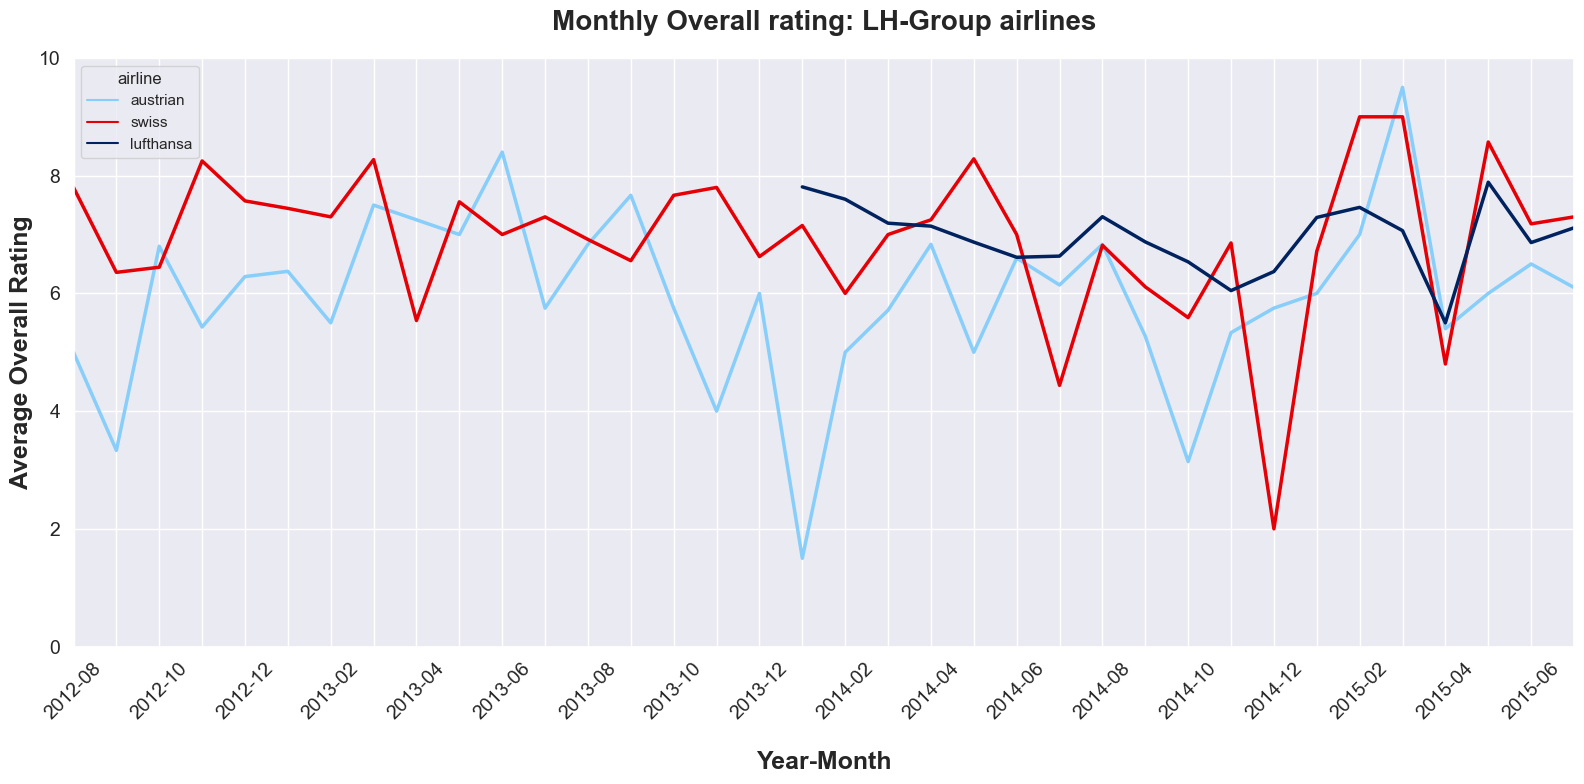

In [29]:
# create ax and figure object
monthlyFig, monthlyAx = plt.subplots(1,1, figsize=(16,8))

monthlyAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=plotPalette, data=monthlyMean, lw=2.5)

xticks = monthlyMean.index.get_level_values(0)

monthlyAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
monthlyAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
monthlyAx.set_title('Monthly Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

monthlyAx.tick_params(axis='x', rotation=45)
monthlyAx.tick_params(axis='both', which='major', labelsize=14)

monthlyAx.set_xlim(xticks[2],xticks[-1])
monthlyAx.set_ylim(0, 10)

# hide every second label -> there is probably a more elegant way to do this, but it works...
for index, label in enumerate(monthlyAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
monthlyFig.tight_layout()
#monthlyFig.savefig('rating_LHGroup.png', dpi=300)

The reviews for LH-Group spread over a longer time frame, which is not the case for most other airlines. Monthly binning leads to an uneven number of samples per bin. The mean for this plot is calculated per month, so it is prone to outliers if few reviews are available for one month 

In [30]:
# check why rating for SWISS drops drastically in 12-2014
test = groupSet[groupSet['airline']=='swiss']
test[test['date']=='2014-12']

,airline,date,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating,recommended,group
50,swiss,2014-12-01,Economy,2.0,1.0,2.0,1.0,1.0,3.0,0,LH-Group


&rarr; Only one review in 12-2014, so mean is not very meaningful here

### Check number of reviews per month

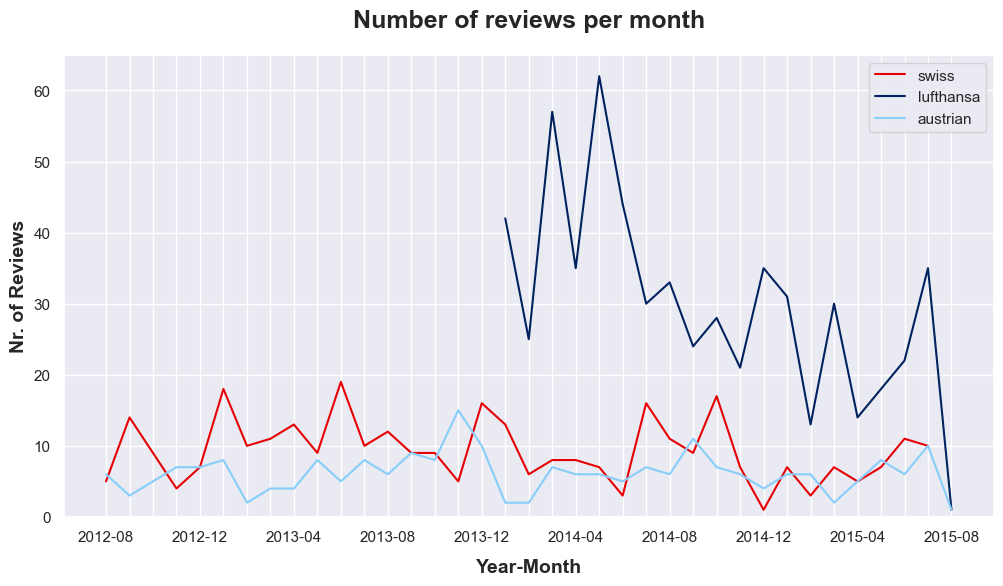

In [31]:
countNumber = groupSet.copy(deep=True)
countNumber['date'] = countNumber['date'].dt.strftime('%Y-%m')

counts = countNumber[['airline','date']].value_counts(sort=False)

countFig, countAx = plt.subplots(1,1, figsize=(12,6))

countAx.set_title('Number of reviews per month',fontsize=18, fontweight='bold', pad=20)
countAx.set_xlabel('Year-Month', fontsize=14, fontweight='bold', labelpad=10)
countAx.set_ylabel('Nr. of Reviews', fontsize=14, fontweight='bold')

countAx.plot(counts['swiss'], color=swissRed, label='swiss')
countAx.plot(counts['lufthansa'], color=lufthansaBlue, label='lufthansa')
countAx.plot(counts['austrian'].loc['2012-08':'2015-08'], color=austrianBlue, label='austrian')

countAx.legend()
countAx.set_ylim(0,65)

labels = countAx.xaxis.get_ticklabels()

for index, label in enumerate(countAx.xaxis.get_ticklabels()):
    if (index) % 4 != 0:
        label.set_visible(False)

#countFig.savefig('n_reviews_LHGroup.png', dpi=300)

### Quaterly average LH-Group

In [32]:
# prepare data
quaterlyMean = plotSet.copy(deep=True)
quaterlyMean['date'] = quaterlyMean['date'].dt.strftime('%Y-%m')
quaterlyMean = quaterlyMean.groupby(['airline','date']).mean()
quaterlyMean = quaterlyMean.reset_index()
quaterlyMean = quaterlyMean.groupby(['airline']).rolling(3,1, on='date').mean()

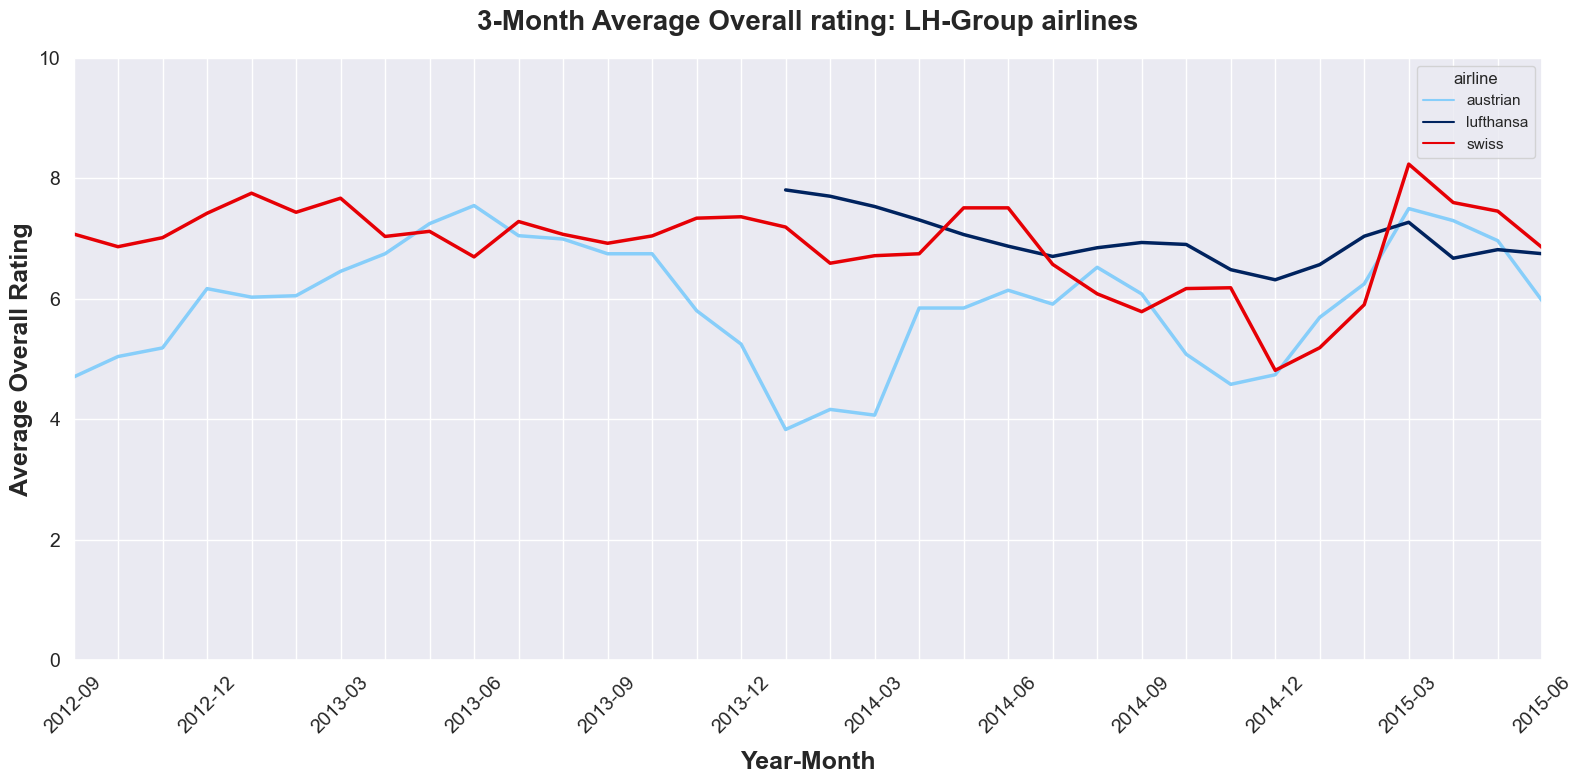

In [33]:
# create ax and figure object
quaterlyFig, quaterlyAx = plt.subplots(1,1, figsize=(16,8))

quaterlyAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=groupPalette, data=quaterlyMean, lw=2.5)

quaterlyAx.set_title('3-Month Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)
quaterlyAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=10)
quaterlyAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')

quaterlyAx.tick_params(axis='both', which='major', labelsize=14)
quaterlyAx.tick_params(axis='x', rotation=45)

quaterlyAx.set_xlim(xticks[4],xticks[-5]) # use xticks from monthlyMean
quaterlyAx.set_ylim(0, 10)

# hide every second label -> there is probably a more elegant way to do this, but it works...
for index, label in enumerate(quaterlyAx.xaxis.get_ticklabels()):
    if (index+2) % 3 != 0:
        label.set_visible(False)
        
quaterlyFig.tight_layout()
#countFig.savefig('3month_average_LHGroup.png', dpi=300)

### Moving average LH-Group

In [34]:
rollingMean = groupSet.copy(deep=True)
rollingMean['date'] = pd.to_datetime(rollingMean['date'])

rollingMean = rollingMean.drop(columns={'cabin_flown'})
rollingMean = rollingMean.drop(columns={'group'})
rollingMean = rollingMean.set_index('date')#.rolling(3).mean()
rollingMean = rollingMean.groupby(['airline']).rolling(20,1).mean()
rollingMean = rollingMean.reset_index()
rollingMean = rollingMean.sort_values(by='date')
rollingMean['date'] = rollingMean['date'].dt.strftime('%Y-%m')

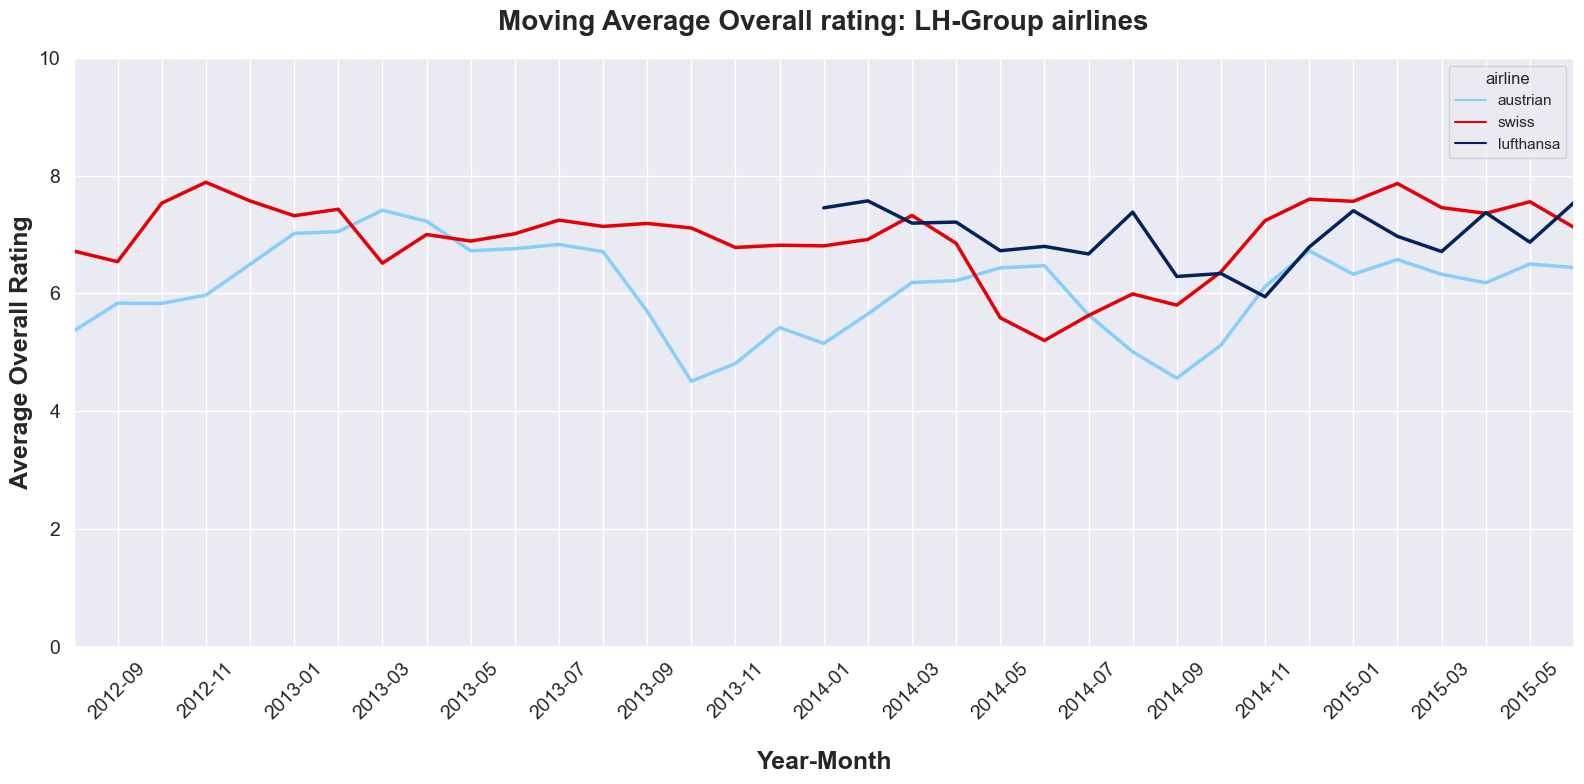

In [35]:
# create ax and figure object
rollingFig, rollingAx = plt.subplots(1,1, figsize=(16,8))

rollingAx = sns.lineplot(x="date", y="overall_rating", hue="airline",
                         palette=groupPalette, data=rollingMean, err_style=None, lw=2.5)

rollingAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
rollingAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
rollingAx.set_title('Moving Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

rollingAx.tick_params(axis='both', which='major', labelsize=14)
rollingAx.tick_params(axis='x', rotation=45)

rollingAx.set_xlim(xticks[2],xticks[-4]) # use xticks from monthlyMean
rollingAx.set_ylim(0, 10)

# hide every second label -> there is probably a more elegant way to do this, but it works...
for index, label in enumerate(rollingAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
rollingFig.tight_layout()
#rollingFig.savefig('moving_average_LHGroup.png', dpi=300)

## 5. Comparison of rating between SWISS and other airlines <a class="anchor" id="chapter5"></a>

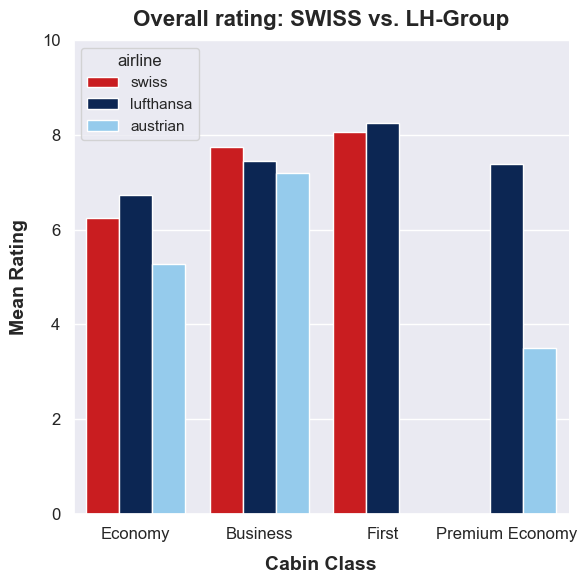

In [36]:
g = sns.catplotg = sns.catplot(
    data=groupSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="airline", palette=groupPalette,
    height=6, errorbar=None, legend_out=False
)
g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Overall rating: SWISS vs. LH-Group',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,10)
g.fig.tight_layout()
#g.savefig('cabinClassLH.png', dpi=300)

(0.0, 10.0)

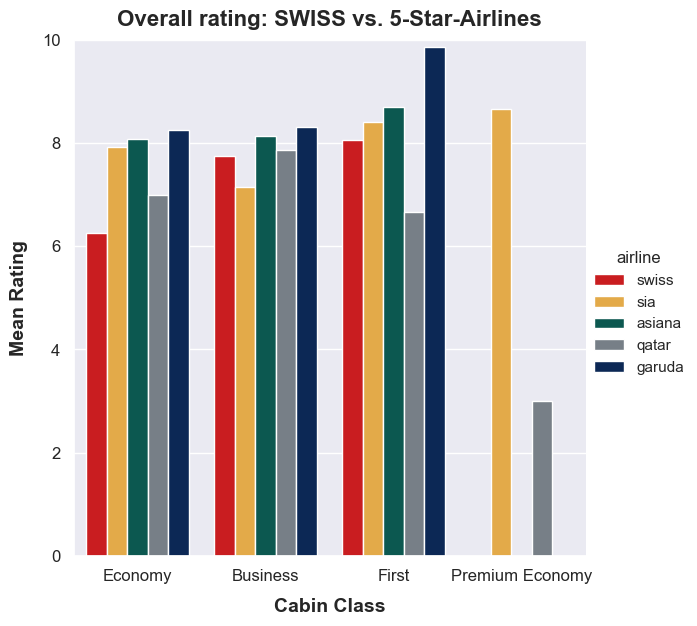

In [37]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Overall rating: SWISS vs. 5-Star-Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)
g.ax.set_ylim(0,10)
#g.savefig('cabinClass5Star.png', dpi=300)

(0.0, 10.0)

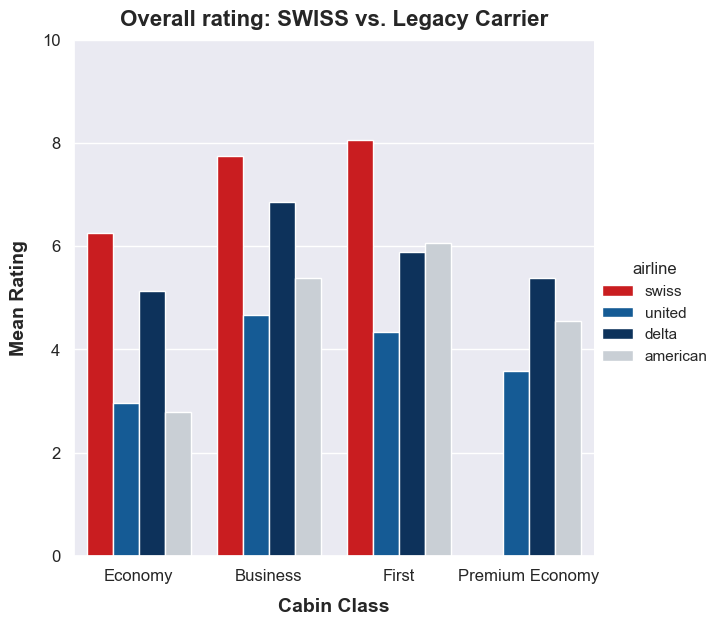

In [38]:
g = sns.catplot(
    data=legacySet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="airline", palette=legacyPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Overall rating: SWISS vs. Legacy Carrier',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,10)
#g.savefig('cabinClassLegacy.png', dpi=300)

(0.0, 10.0)

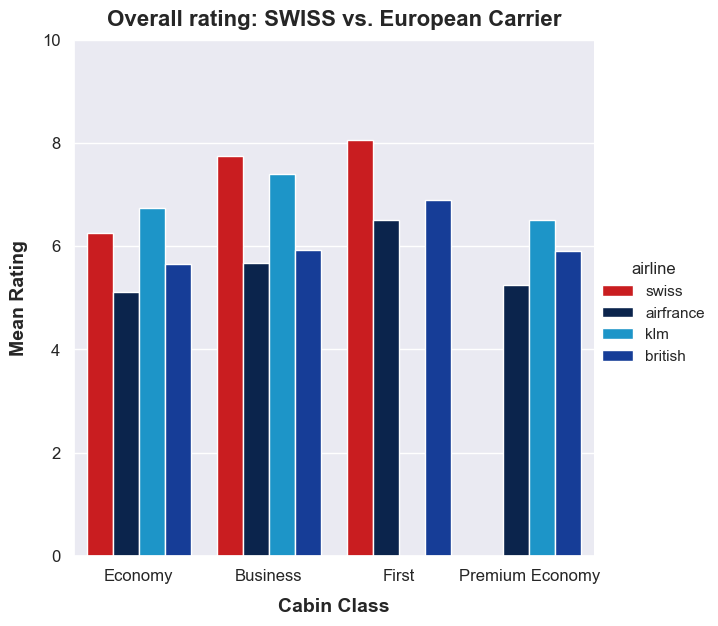

In [39]:
g = sns.catplot(
    data=europeanSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="airline", palette=europeanPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Overall rating: SWISS vs. European Carrier',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,10)
#g.savefig('cabinClassEuropean.png', dpi=300)

In [40]:
# drop data for premium economy, as SWISS did not have a premium eco in 2015

fiveStarSet = fiveStarSet[fiveStarSet.cabin_flown != 'Premium Economy']

(0.0, 5.0)

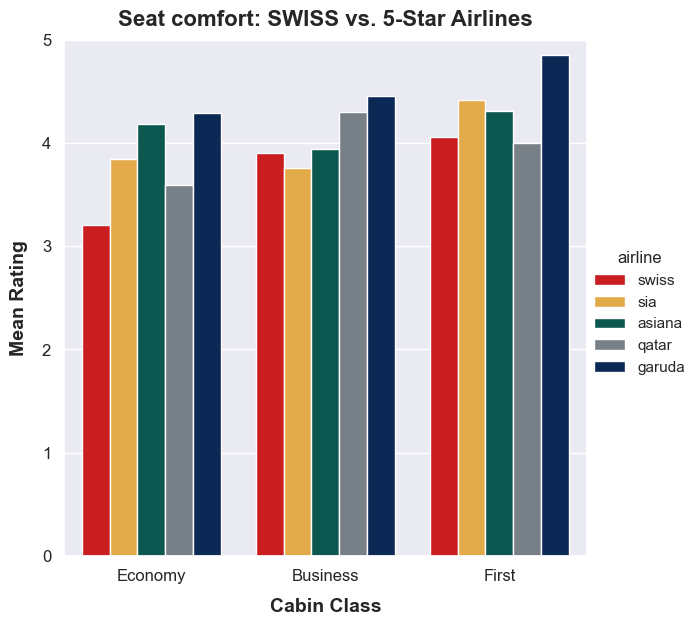

In [41]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="seat_comfort_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Seat comfort: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,5)
#g.savefig('compareSeat.png', dpi=300)

(0.0, 5.0)

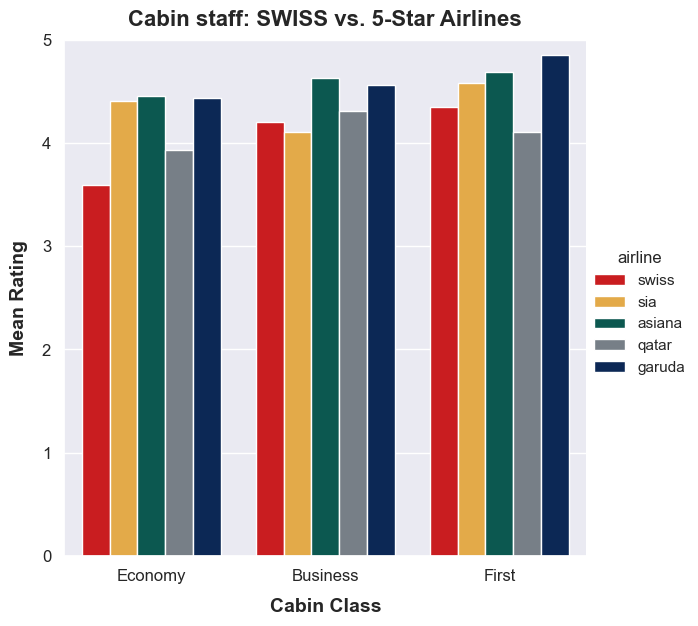

In [42]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="cabin_staff_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Cabin staff: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,5)
#g.savefig('compareStaff.png', dpi=300)

(0.0, 5.0)

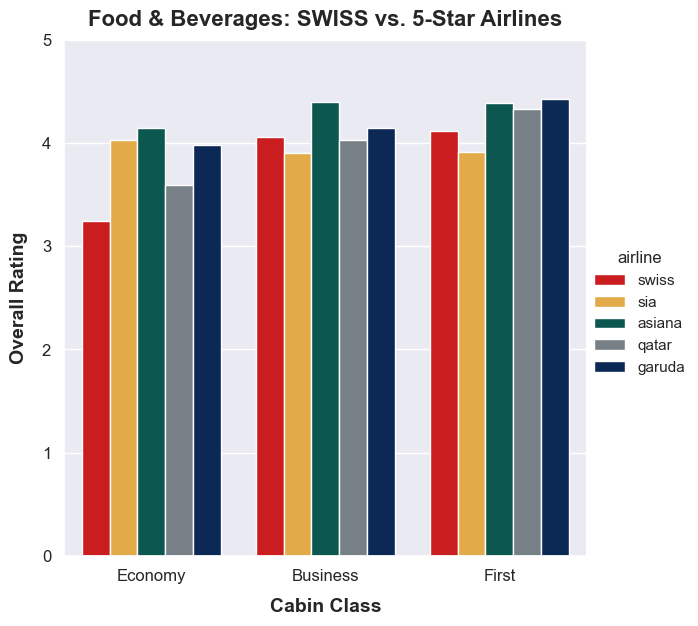

In [43]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="food_beverages_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Overall Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Food & Beverages: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,5)
#g.savefig('compareFood.png', dpi=300)

(0.0, 5.0)

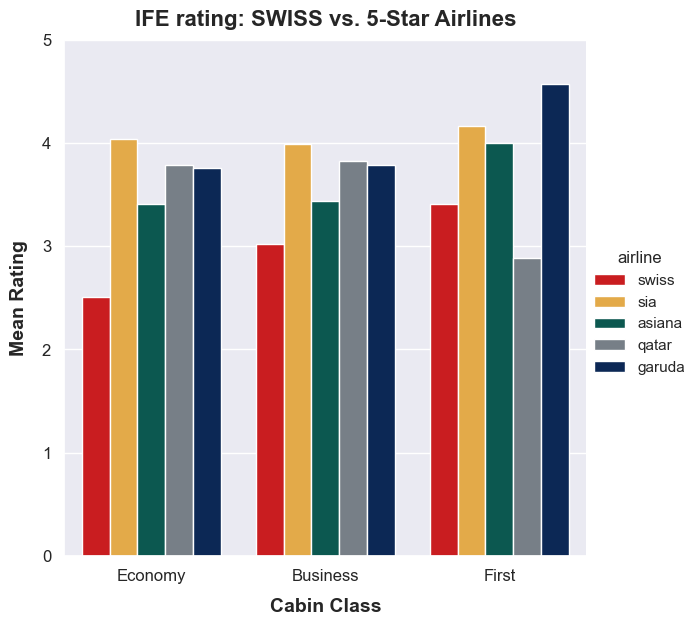

In [44]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="inflight_entertainment_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean Rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('IFE rating: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,5)
#g.savefig('compareIFE.png', dpi=300)

(0.0, 5.0)

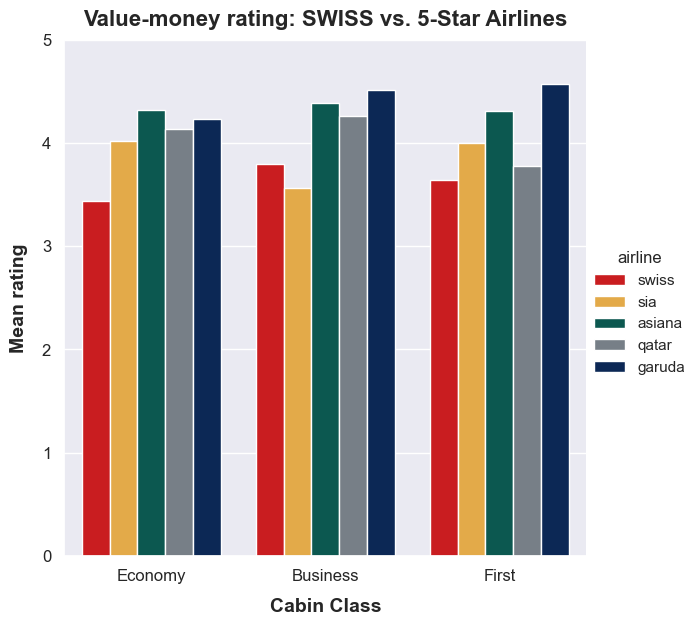

In [45]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="value_money_rating", hue="airline", palette=fiveStarPalette,
    height=6, errorbar=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Value-money rating: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

g.ax.set_ylim(0,5)
#g.fig.tight_layout()
#g.savefig('compareValue.png', dpi=300)

## 6. Cluster analysis <a class="anchor" id="chapter6"></a>

In the next step we want to analyse how the different airlines form clusters according to their customer rating and if these reflect the Skytray World Airline Awards (https://www.worldairlineawards.com/the-worlds-top-100-airlines-2015/)

### Preparation

In [46]:
# lowcost carrier
ryanair = get_airline_data("ryanair")
easyjet = get_airline_data("easyjet")
norwegian = get_airline_data("norwegian")
airasia = get_airline_data("airasia")

lowcost = {'ryanair' : ryanair, 'easyjet' : easyjet, 'norwegian' : norwegian, 'airasia' : airasia}
lowcost = clean_metadata(lowcost)
lowcost = remove_nan(lowcost)

#get_missing_data(lowcost)

lowcostSet = pd.concat([lowcost['ryanair'], lowcost['easyjet'], lowcost['norwegian'], lowcost['airasia'],])
lowcostSet['group'] = 'Lowcost'

Dataset for RYANAIR                        contains 658 data points
Dataset for EASYJET                        contains 447 data points
Dataset for NORWEGIAN                      contains 449 data points
Dataset for AIRASIA                        contains 308 data points
RYANAIR   : Removed  23 of 658 rows (3.5%)
EASYJET   : Removed  17 of 447 rows (3.8%)
NORWEGIAN : Removed  60 of 449 rows (13.36%) -> WARNING: more than 10% of rows were dropped
AIRASIA   : Removed  44 of 308 rows (14.29%) -> WARNING: more than 10% of rows were dropped



In [47]:
# merge all datasets into one large airline data set

# remove swiss from other data sets (was added to compare groupwise)
fiveStarSet = fiveStarSet.drop(fiveStarSet[fiveStarSet.airline=='swiss'].index)
europeanSet = europeanSet.drop(europeanSet[europeanSet.airline=='swiss'].index)
legacySet = legacySet.drop(legacySet[legacySet.airline=='swiss'].index)

# merge all 5 datasets
allAirlines = pd.concat([groupSet, fiveStarSet, legacySet, europeanSet, lowcostSet])
allAirlines = allAirlines.rename(columns={'group' : 'Airline-Group'})

In [48]:
# define colors

lowcostColor = 'green'
lhGroupColor = lufthansaBlue
legacyColor = americanGray
europeanColor = klmBlue
fiveStarColor = siaOrange

lowCostLabel = 'Lowcost'
lgGroupLabel = 'LH-Group'

allPalette = {'FiveStar' : fiveStarColor, 'European' : europeanColor, 'Legacy' : legacyColor,
              'LH-Group' : lhGroupColor, 'Lowcost' : lowcostColor}

In [49]:
# calculate mean for all airlines 

meanRating = allAirlines.groupby(['Airline-Group','airline']).mean()
stdRating = allAirlines.groupby(['Airline-Group','airline']).std()

# rearange columns
meanRating = meanRating[['seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'value_money_rating', 'overall_rating', 'recommended']]

# define categories for indexing
categories = ['seat_comfort_rating', 'cabin_staff_rating',
              'food_beverages_rating', 'inflight_entertainment_rating', 'value_money_rating']

# show mean table
meanRating
#stdRating

seat_comfort_rating  cabin_staff_rating  \
Airline-Group airline                                              
European      airfrance             2.645161            2.935484   
              british               3.229130            3.495560   
              klm                   3.558824            4.205882   
FiveStar      garuda                4.562500            4.937500   
              qatar                 3.974194            4.006452   
              sia                   3.863158            4.315789   
LH-Group      austrian              3.101083            3.545126   
              lufthansa             3.371667            4.085000   
              swiss                 3.497024            3.851190   
Legacy        american              2.630435            2.612319   
              delta                 3.238462            3.353846   
              united                2.428571            2.418651   
Lowcost       airasia               3.189394            3.397727   
              easyjet               3.311628            3.553488   
              norwegian             3.550129            3.406170   
              ryanair               2.878740            3.047244   

                         food_beverages_rating  inflight_entertainment_rating  \
Airline-Group airline                                                           
European      airfrance               2.693548                       2.725806   
              british                 3.046181                       2.570160   
              klm                     3.676471                       3.500000   
FiveStar      garuda                  4.125000                       3.875000   
              qatar                   3.832258                       3.890323   
              sia                     3.957895                       4.168421   
LH-Group      austrian                3.379061                       2.259928   
              lufthansa               3.580000                       3.353333   
              swiss                   3.580357                       2.738095   
Legacy        american                2.362319                       1.992754   
              delta                   2.946154                       2.684615   
              united                  2.009921                       2.035714   
Lowcost       airasia                 2.390152                       0.939394   
              easyjet                 2.330233                       1.000000   
              norwegian               2.200514                       2.781491   
              ryanair                 1.743307                       2.000000   

                         value_money_rating  overall_rating  recommended  
Airline-Group airline                                                     
European      airfrance            2.790323        4.709677     0.467742  
              british              3.248668        5.895204     0.575488  
              klm                  3.764706        7.588235     0.823529  
FiveStar      garuda               4.687500        8.812500     1.000000  
              qatar                4.141935        7.348387     0.774194  
              sia                  3.936842        7.915789     0.842105  
LH-Group      austrian             3.274368        5.898917     0.552347  
              lufthansa            3.683333        6.993333     0.813333  
              swiss                3.577381        6.883929     0.717262  
Legacy        american             2.594203        3.923913     0.347826  
              delta                3.146154        5.669231     0.546154  
              united               2.283730        3.353175     0.248016  
Lowcost       airasia              3.670455        6.136364     0.655303  
              easyjet              3.683721        6.597674     0.681395  
              norwegian            3.578406        6.143959     0.593830  
              ryanair              3.281890        5.576378     0.

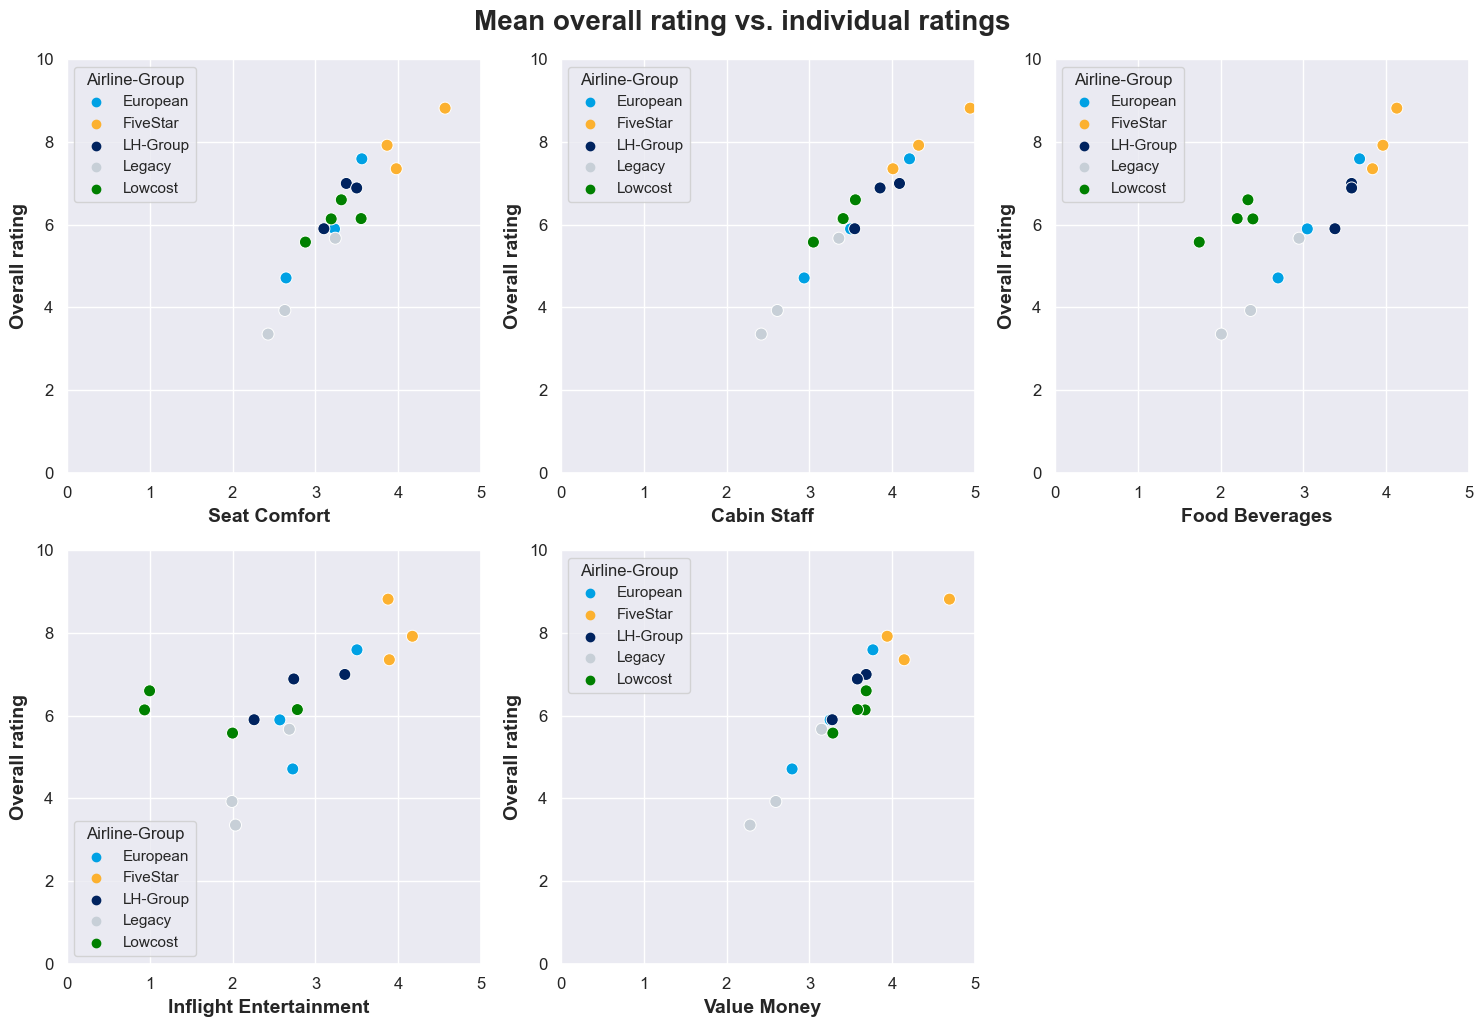

In [50]:
meanFig, meanAx = plt.subplots(2,3, figsize=(15,10))
meanFig.suptitle('Mean overall rating vs. individual ratings',y = 1.025, size=20, fontweight='bold')

categories = ['seat_comfort_rating', 'cabin_staff_rating',
              'food_beverages_rating', 'inflight_entertainment_rating', 'value_money_rating']

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Value-money rating: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

for i in range(2):
    for j in range(3):
        idx = 3*i + j
                
        if idx < 5:
            sns.scatterplot(data=meanRating, x=categories[idx], y='overall_rating',
                            hue='Airline-Group', palette=allPalette, ax=meanAx[i][j], s=75)
            
            # create xLabel
            xLabel = string.capwords(categories[idx].replace("_"," ")).replace("Rating", " ")
            
            meanAx[i][j].set_xlabel(xLabel, fontsize=14, fontweight='bold', labelpad=5)
            meanAx[i][j].set_ylabel('Overall rating', fontsize=14, fontweight='bold', labelpad=5)
            meanAx[i][j].tick_params(axis='both', which='major', labelsize=12)
        
        if idx == 5:
            meanAx[i][j].set_visible(False)
        
        meanAx[i][j].set_xlim(0,5)
        meanAx[i][j].set_ylim(0,10)  
        
        
        
meanFig.tight_layout()
#meanFig.savefig('meanFigure.png', dpi=300)

### k-mean clustering

We use simple k-means clustering to identify four quality groups of airlines.

In [51]:
from sklearn.cluster import KMeans

In [52]:
# prepare input - drop binary variable recommended
X_kMeans = meanRating.drop(columns={'recommended'})

# create kmeans object, fit data and predict labels
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_kMeans)
kmeans_labels = kmeans.predict(X_kMeans)

In [53]:
meanRatingClustered = meanRating.copy(deep=True)
meanRatingClustered['cluster'] = kmeans_labels
meanRatingClustered = meanRatingClustered[['cluster', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'value_money_rating', 'recommended']]
meanRatingClustered = meanRatingClustered.reset_index()

In [54]:
# show result
meanRatingClustered.groupby(['cluster', 'airline']).mean().sort_values('overall_rating', ascending=False)

overall_rating  seat_comfort_rating  cabin_staff_rating  \
cluster airline                                                              
0       garuda           8.812500             4.562500            4.937500   
        sia              7.915789             3.863158            4.315789   
        klm              7.588235             3.558824            4.205882   
        qatar            7.348387             3.974194            4.006452   
        lufthansa        6.993333             3.371667            4.085000   
        swiss            6.883929             3.497024            3.851190   
2       easyjet          6.597674             3.311628            3.553488   
        norwegian        6.143959             3.550129            3.406170   
        airasia          6.136364             3.189394            3.397727   
        austrian         5.898917             3.101083            3.545126   
        british          5.895204             3.229130            3.495560   
        delta            5.669231             3.238462            3.353846   
        ryanair          5.576378             2.878740            3.047244   
1       airfrance        4.709677             2.645161            2.935484   
        american         3.923913             2.630435            2.612319   
        united           3.353175             2.428571            2.418651   

                   food_beverages_rating  inflight_entertainment_rating  \
cluster airline                                                           
0       garuda                  4.125000                       3.875000   
        sia                     3.957895                       4.168421   
        klm                     3.676471                       3.500000   
        qatar                   3.832258                       3.890323   
        lufthansa               3.580000                       3.353333   
        swiss                   3.580357                       2.738095   
2       easyjet                 2.330233                       1.000000   
        norwegian               2.200514                       2.781491   
        airasia                 2.390152                       0.939394   
        austrian                3.379061                       2.259928   
        british                 3.046181                       2.570160   
        delta                   2.946154                       2.684615   
        ryanair                 1.743307                       2.000000   
1       airfrance               2.693548                       2.725806   
        american                2.362319                       1.992754   
        united                  2.009921                       2.035714   

                   value_money_rating  recommended  
cluster airline                                     
0       garuda               4.687500     1.000000  
        sia                  3.936842     0.842105  
        klm                  3.764706     0.823529  
        qatar                4.141935     0.774194  
        lufthansa            3.683333     0.813333  
        swiss                3.577381     0.717262  
2       easyjet              3.683721     0.681395  
        norwegian            3.578406     0.593830  
        airasia              3.670455     0.655303  
        austrian             3.274368     0.552347  
        british              3.248668     0.575488  
        delta                3.146154     0.546154  
        ryanair              3.281890     0.533858  
1       airfrance            2.790323     0.467742  
        american             2.594203     0.347826  
        united               2.283730     0.248016

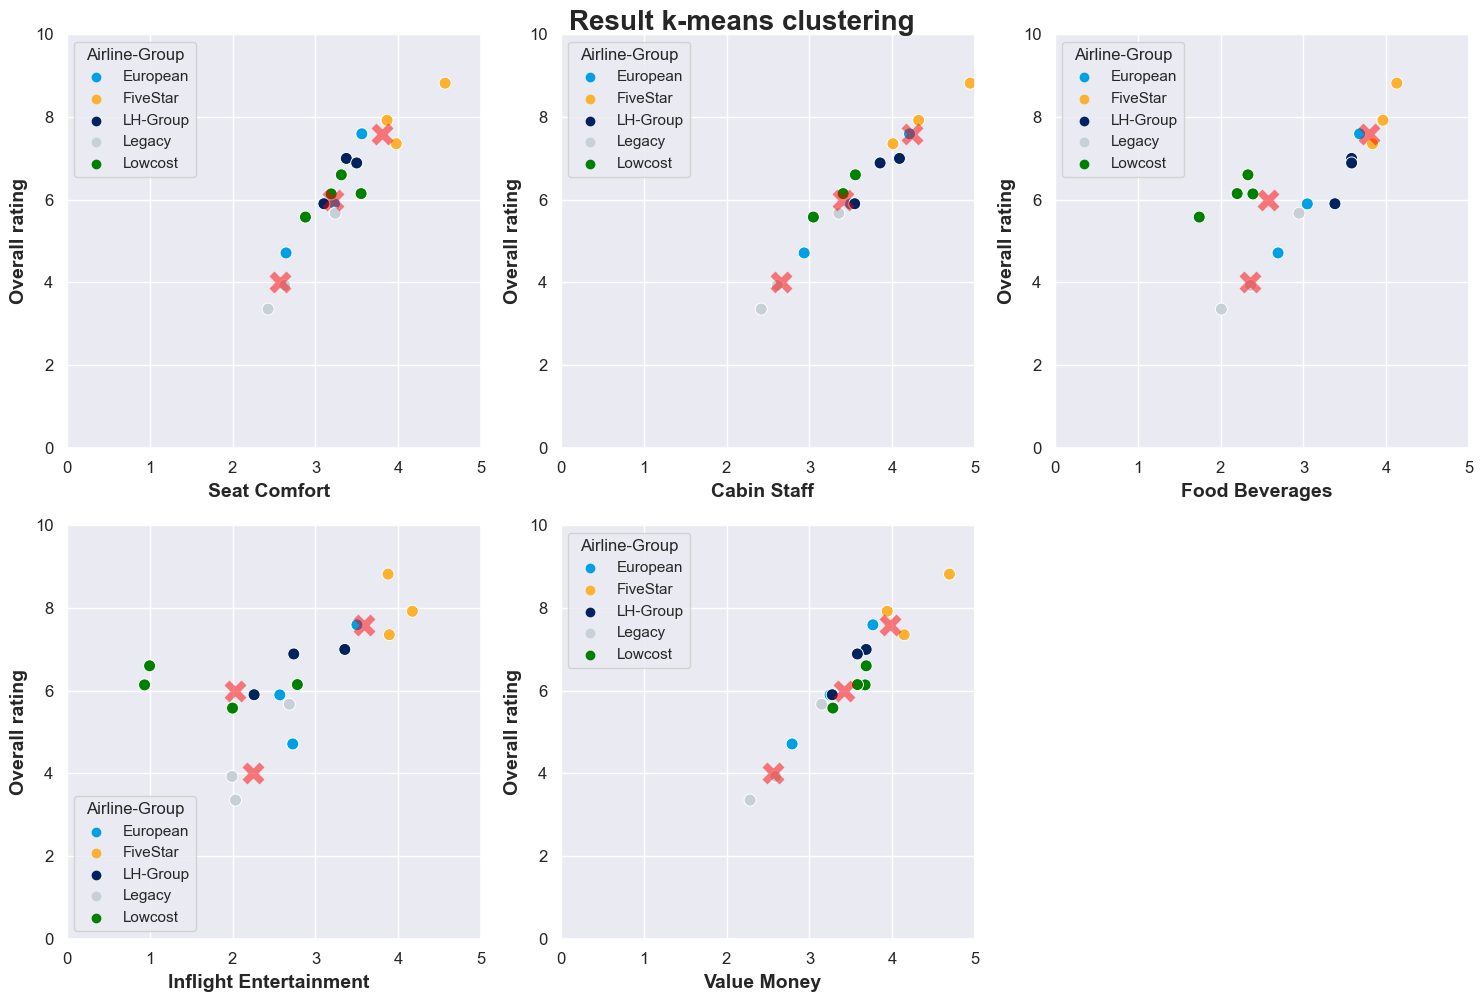

In [55]:
# plot result of kmean clustering

kmeanFig, kmeanAx = plt.subplots(2,3, figsize=(15,10))
kmeanFig.suptitle('Result k-means clustering',y = 1, size=20, fontweight='bold')

categories = ['seat_comfort_rating', 'cabin_staff_rating',
              'food_beverages_rating', 'inflight_entertainment_rating', 'value_money_rating']

g.ax.set_xlabel('Cabin Class', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_ylabel('Mean rating', fontsize=14, fontweight='bold', labelpad=10)
g.ax.set_title('Value-money rating: SWISS vs. 5-Star Airlines',fontsize=16, fontweight='bold', pad=10)
g.ax.tick_params(axis='both', which='major', labelsize=12)

for i in range(2):
    for j in range(3):
        idx = 3*i + j
                
        if idx < 5:
            sns.scatterplot(data=meanRating, x=categories[idx], y='overall_rating',
                            hue='Airline-Group', palette=allPalette, ax=kmeanAx[i][j], s=75)
            
            # create xLabel
            xLabel = string.capwords(categories[idx].replace("_"," ")).replace("Rating", " ")
            
            kmeanAx[i][j].set_xlabel(xLabel, fontsize=14, fontweight='bold', labelpad=5)
            kmeanAx[i][j].set_ylabel('Overall rating', fontsize=14, fontweight='bold', labelpad=5)
            kmeanAx[i][j].tick_params(axis='both', which='major', labelsize=12)
            
            kmeans_Y = kmeans.cluster_centers_[:,-1]
            kmeans_X = kmeans.cluster_centers_[:,idx]
            
            kmeanAx[i][j].scatter(kmeans_X, kmeans_Y, marker='x', s=150,
                                  c='red', linewidth=5, alpha=0.5, label='cluster\n')
        
        if idx == 5:
            kmeanAx[i][j].set_visible(False)
        
        kmeanAx[i][j].set_xlim(0,5)
        kmeanAx[i][j].set_ylim(0,10)
        #kmeanAx[i][j].legend()
        
        
        
        
kmeanFig.tight_layout()
#kmeanFig.savefig('meanFigureCluster.png', dpi=300)

## 7. Correlation analysis <a class="anchor" id="chapter7"></a>

Before performing classifcation/regression tasks, we analyse the crosscorrelation between the differetn features to identify which features might have a strong influence on **recommendation** and **overall_rating**

In [56]:
lhGroupCorr = groupSet.corr()
fiveStarCorr = fiveStarSet.corr()
legacyCorr = legacySet.corr()
europeanCorr = europeanSet.corr()

colormap = plt.cm.Blues

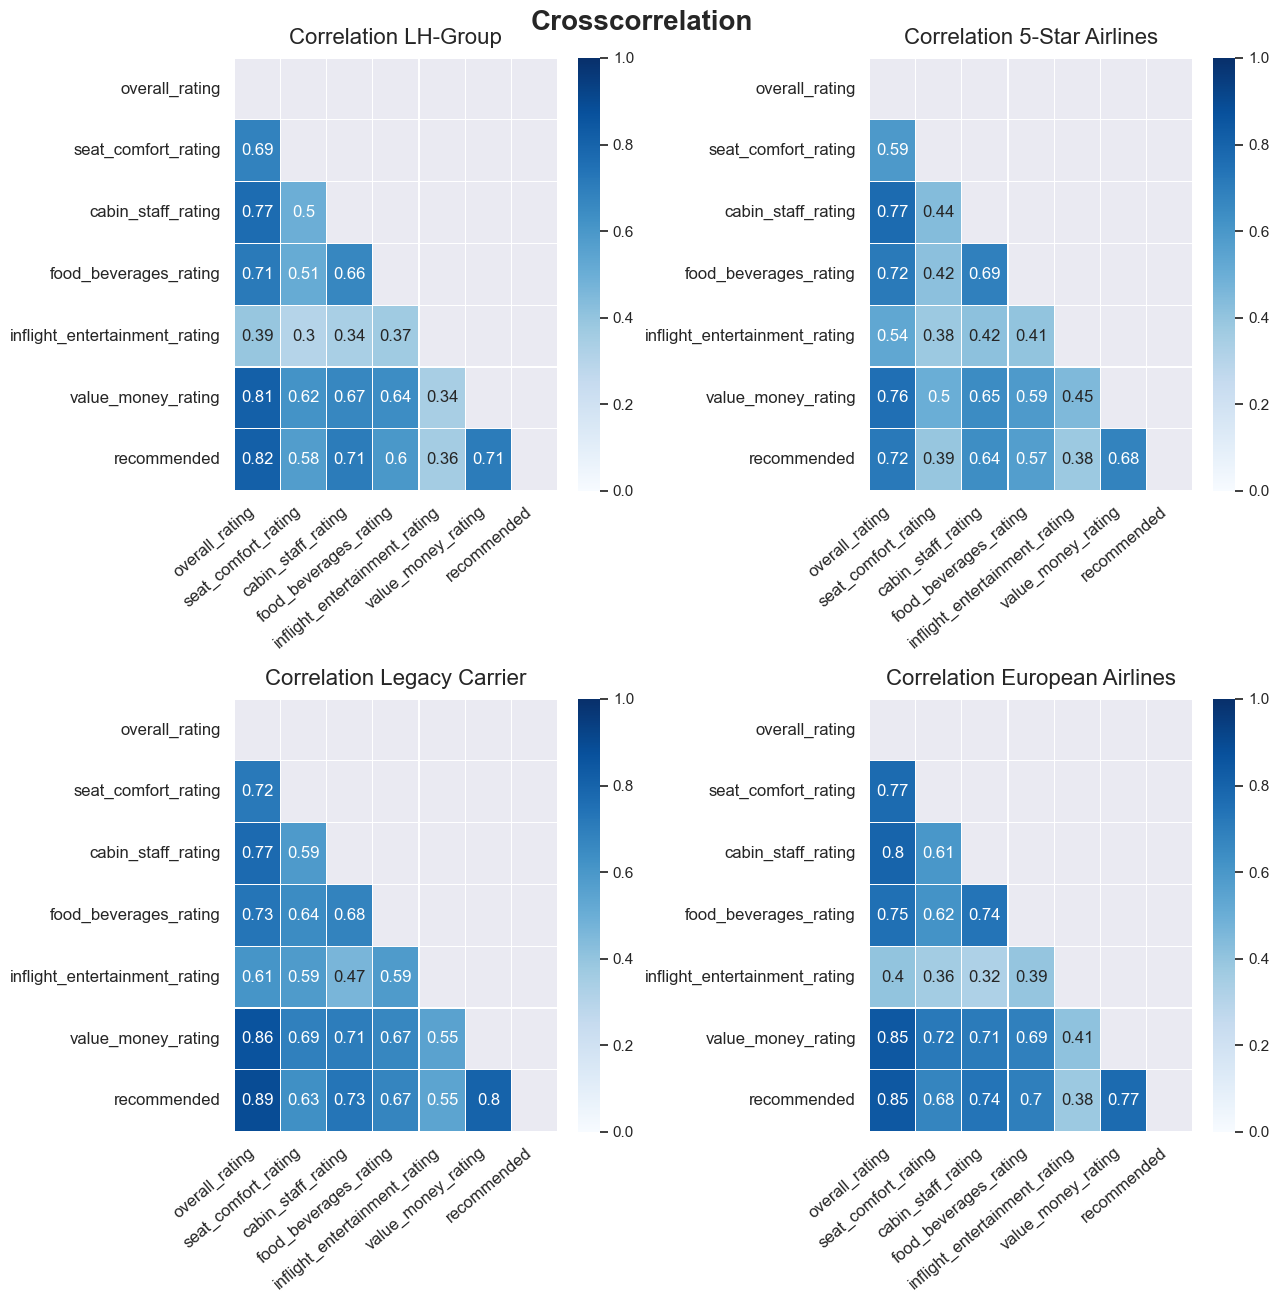

In [57]:
# Question: which factors correlate with each other -> are there major differences

corFig0, corAx0 = plt.subplots(2,2, figsize=(13,13))
corFig0.suptitle('Crosscorrelation',y = 1, size=20, fontweight='bold')

lhMask = np.zeros_like(lhGroupCorr)
fiveStarMask = np.zeros_like(fiveStarCorr)
legacyMask = np.zeros_like(legacyCorr)
europeanMask = np.zeros_like(europeanCorr)

lhMask[np.triu_indices_from(lhMask)] = True
fiveStarMask[np.triu_indices_from(fiveStarMask)] = True
legacyMask[np.triu_indices_from(legacyMask)] = True
europeanMask[np.triu_indices_from(europeanMask)] = True

sns.heatmap(lhGroupCorr, mask=lhMask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True, ax=corAx0[0][0])

sns.heatmap(fiveStarCorr, mask=fiveStarMask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True, ax=corAx0[0][1])

sns.heatmap(legacyCorr, mask=legacyMask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True, ax=corAx0[1][0])

sns.heatmap(europeanCorr, mask=europeanMask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True, ax=corAx0[1][1])

corAx0[0][0].set_title('Correlation LH-Group',fontsize=16, pad=10)
corAx0[0][1].set_title('Correlation 5-Star Airlines',fontsize=16, pad=10)
corAx0[1][0].set_title('Correlation Legacy Carrier',fontsize=16, pad=10)
corAx0[1][1].set_title('Correlation European Airlines',fontsize=16, pad=10)

for i in range(2):
    for j in range(2):
        xlabels = corAx0[i][j].xaxis.get_ticklabels()
        corAx0[i][j].set_xticklabels(xlabels, rotation=40, ha='right')
        corAx0[i][j].tick_params(axis='both', which='major', labelsize=12)

corFig0.tight_layout()
#corFig0.savefig('correlation.png', dpi=300)

## 8. Logistic regression to predict customer recommendation <a class="anchor" id="chapter8"></a>

We try to build a simple logistic regression model to predict whether a customer recommends the airline or not.

### Logistic regression

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [59]:
airline = allAirlines[allAirlines['airline']=='swiss']

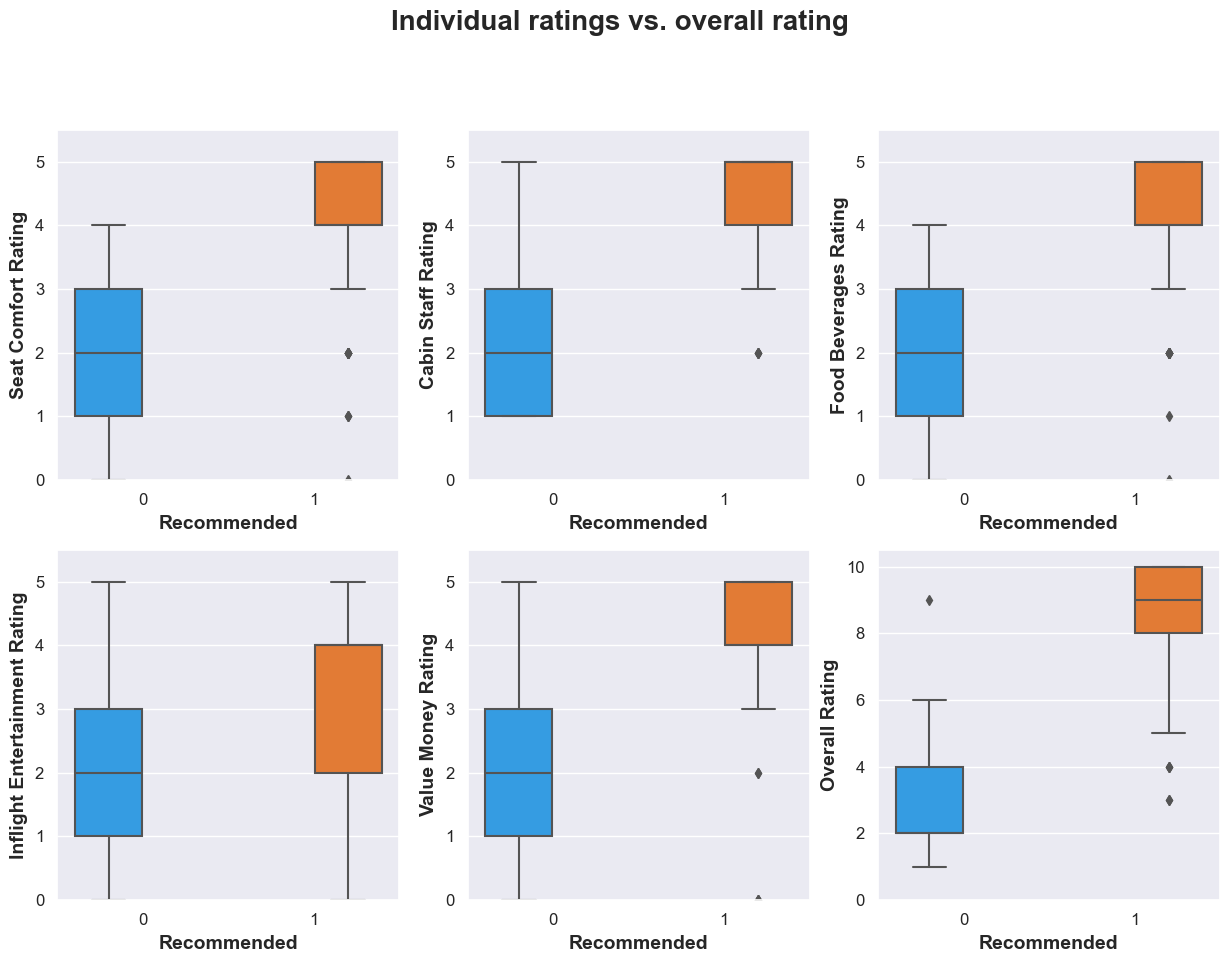

In [60]:
regFig, regAx = plt.subplots(2,3, figsize=(15,10))
regFig.suptitle("Individual ratings vs. overall rating", y = 1.0, size=20, fontweight='bold')



xValue = airline['overall_rating']
yValue = [airline['seat_comfort_rating'], airline['cabin_staff_rating'],
          airline['food_beverages_rating'], airline['inflight_entertainment_rating'], 
          airline['value_money_rating'], airline['overall_rating']]

categories = ['seat_comfort_rating', 'cabin_staff_rating',
              'food_beverages_rating', 'inflight_entertainment_rating', 'value_money_rating', 'overall_rating']

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        
        jittered_y = xValue + 0.2 * np.random.rand(len(xValue)) -0.1
        jittered_x = yValue[idx] + 0.2 * np.random.rand(len(yValue[idx])) -0.1
        
        sns.boxplot(data=airline, y=categories[idx], x='recommended',
                      hue='recommended', ax=regAx[i][j], palette=binaryPalette)
        
        xLabel = string.capwords(categories[idx].replace("_"," "))#.replace("Rating", " ")
            
        regAx[i][j].set_xlabel('Recommended', fontsize=14, fontweight='bold', labelpad=5)
        regAx[i][j].set_ylabel(xLabel, fontsize=14, fontweight='bold', labelpad=5)
        regAx[i][j].tick_params(axis='both', which='major', labelsize=12)
            
        regAx[i][j].set_ylim(0,5.5)
        
        if idx == 5:
            regAx[i][j].set_visible(True)
            regAx[i][j].set_ylim(0,10.5)
        
        regAx[i][j].get_legend().remove()

#regFig.tight_layout()
#regFig.savefig('recommendation.png', dpi=300)

In [61]:
# prepare input data -> drop all columns with non numeric values
regressionSet = airline.drop(columns={'date', 'cabin_flown', 'Airline-Group', 'airline'})

In [62]:
# select columns for x and y data
Y_colLog = 'recommended'
X_colsLog = regressionSet.loc[:, regressionSet.columns != Y_colLog].columns

In [63]:
# split data set into training and test set
xLog_train, xLog_test, yLog_train, yLog_test =train_test_split(regressionSet[X_colsLog],
                                                               regressionSet[Y_colLog], test_size=0.3)

In [64]:
# create obejct for logistic regression
logisticRegr = LogisticRegression()

In [65]:
# fit model
logisticRegr.fit(xLog_train, yLog_train)

LogisticRegression()

In [66]:
# predict values for test set
predictions = logisticRegr.predict(xLog_test)

In [67]:
score_train = logisticRegr.score(xLog_train, yLog_train)
score_test = logisticRegr.score(xLog_test, yLog_test)
print(f"Score for training set: {score_train}")
print(f"Score for test set    : {score_test}")

Score for training set: 0.9617021276595744
Score for test set    : 0.9306930693069307


In [68]:
# test model for all other airlines

allAirlinesSet = allAirlines
allAirlinesSet = allAirlinesSet.drop(columns={'date', 'cabin_flown', 'Airline-Group', 'airline'})
x_airline2 = allAirlinesSet[X_colsLog]
y_airline2 = allAirlinesSet[Y_colLog]

score_airlines = logisticRegr.score(x_airline2, y_airline2)
print(f"Score for all other airlines: {score_airlines}")

Score for all other airlines: 0.9402014267729752


## 9. Linear regression to predict overall rating <a class="anchor" id="chapter9"></a>

We try to build a simple logistic regression model to predict whether a customer recommends the airline or not.

In [69]:
# prepare input data -> drop binary variable recommended
Y_colReg = 'overall_rating'
X_colsReg = regressionSet.loc[:, regressionSet.columns != Y_colReg].columns
X_colsReg = X_colsReg.drop(['recommended'])

In [70]:
# split data set into training and test set
xReg_train, xReg_test, yReg_train, yReg_test = train_test_split(regressionSet[X_colsReg],
                                                                regressionSet[Y_colReg], test_size=0.2)

In [71]:
# create obejct for logistic regression
linRegr = LinearRegression()

In [72]:
# fit model
linRegr.fit(xReg_train, yReg_train)

LinearRegression()

In [73]:
# predict values for test set
predictions = np.around(linRegr.predict(xReg_test))

In [74]:
# show predicted overall_rating for test set
predictions

array([ 2.,  7.,  8.,  8.,  9.,  5.,  5.,  9.,  4.,  9.,  8.,  4.,  4.,
        8.,  5.,  2.,  2.,  8.,  5.,  9.,  1.,  5.,  7., 10.,  9.,  9.,
        5., 10.,  8., 10., 10.,  8.,  8., 10.,  6.,  9.,  8., 10.,  8.,
        9.,  3.,  9.,  9.,  9., 10., 10.,  3.,  9., 10.,  9.,  3.,  9.,
        0., 10.,  8.,  2.,  7.,  4.,  6.,  4.,  7.,  8.,  4.,  4.,  7.,
        8., 10., 10.])

In [75]:
# show true overall_rating
yReg_test

249     2.0
160     5.0
60      9.0
304     8.0
259    10.0
       ... 
156     3.0
227    10.0
190     9.0
36     10.0
24     10.0
Name: overall_rating, Length: 68, dtype: float64

In [76]:
# calculate Root Mean Squared error (RMSE) and r2 score
test_set_rmse = (np.sqrt(mean_squared_error(yReg_test, predictions)))
test_set_r2 = r2_score(yReg_test, predictions)

In [77]:
print(f"Test set RMSE    : {test_set_rmse}")
print(f"Test set r2-score: {test_set_r2}")

Test set RMSE    : 1.3284223283101428
Test set r2-score: 0.8162286332004595


## 10. Conclusions <a class="anchor" id="chapter10"></a>

* Introduce Premium Economy Class?
* Improve Economy Product
* IFE has a huge quality gap to 5-Star airlines
